In [1]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile as sf

import librosa 
import seaborn as sns

# managing parameters
from parammanager import paramManager
import nsjsonmanager 
#from Tf_record import tfrecordManager

#Synth Interface (SI)
from genericsynth import synthInterface as SI # the base model for all synths, also some utilities 

#### Demo of synth interface using the single pop synth 

Note: Grain and GaussGrains are both synths that derive from the SI.MySoundModel class (and thus have the interface for parameter setting/getting as well as the generate() function for creating audio.

Here we load GaussGrain just to see the interface in action. Normally it would only be used by PatternSynth (in GaussGrains_0001.py), and not loaded in a notebook or dataset generating program. 

In [2]:
from GaussGrain import GaussGrain   # This is the single-event synth that GaussGrains uses [loading just for viz purposes]
foosynth=GaussGrain(440, 1)   # can (optionally) set params for a synth when you create an instance

foosynth.setParam('amp', .6) # Can set any synth parameter with setParam()
print(f" the current val or amp is {foosynth.getParam('amp')}, and its minval is {foosynth.getParam('amp', 'min')}")
foosynth.printParams()
foosynth.getParams()    # Get a param values. 


GaussGrain creating rng with default seed
 the current val or amp is 0.6, and its minval is 0
Name:  cf  Current value :  440 , Min value  40 , Max value  2000 , synth_doc:  center frequency in Hz
Name:  nocts  Current value :  1 , Min value  -3 , Max value  3 , synth_doc:  frequency sweep in octaves centered around cf
Name:  comps  Current value :  1 , Min value  1 , Max value  10 , synth_doc:  number of harmonic components including fundamental
Name:  amp  Current value :  0.6 , Min value  0 , Max value  1 , synth_doc:  [0,1] amplitude


['cf', 'nocts', 'comps', 'amp']

In [3]:
fmin = foosynth.getParam('cf', "min")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmin))

foosynth.setParam('cf', 1000)   #setParamNorm uses [0,1] range 
foosynth.setParam('nocts', 2)
foosynth.setParam('comps', 2)

foosynth.printParams()    # Get a param values. 

min val of synth param f0 is 40
Name:  cf  Current value :  1000 , Min value  40 , Max value  2000 , synth_doc:  center frequency in Hz
Name:  nocts  Current value :  2 , Min value  -3 , Max value  3 , synth_doc:  frequency sweep in octaves centered around cf
Name:  comps  Current value :  2 , Min value  1 , Max value  10 , synth_doc:  number of harmonic components including fundamental
Name:  amp  Current value :  0.6 , Min value  0 , Max value  1 , synth_doc:  [0,1] amplitude


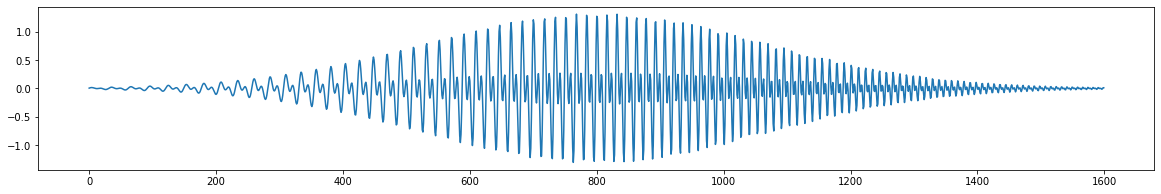

In [4]:
sig=foosynth.generate(.1, .75)   # all synths use generate to create audio. Parameter is length in seconds

plt.figure(figsize=(20,3))
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=False))

#### Demo of synth interface using the main GaussGrains_0001

GaussGrains_0001 creating rng with default seed
GaussGrain creating rng with default seed
 seq hi freq = 1703.5515072193023, and lo = 440.5318924758043


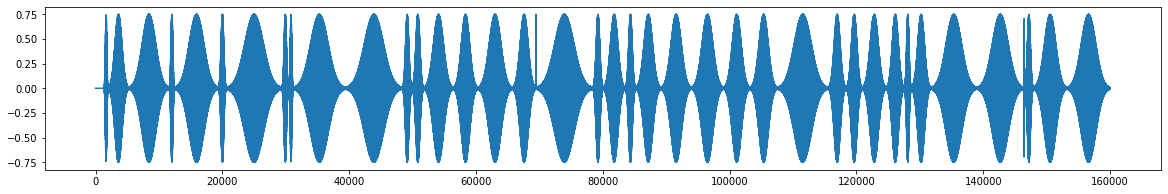

In [11]:
from GaussGrains_0001 import GaussGrains_0001

barsynth=GaussGrains_0001() #rngseed must *explicitly* be set to none if you want a random seed
barsynth.setParam("rate_exp",2) # will make 2^1 events per second
barsynth.setParam("irreg_exp", 1)
barsynth.setParam("nocts", 0)
barsynth.setParam("durdutyexp", 0)

barsynth.setParam("cf_exp", 1.) #re 440
barsynth.setParam("cfrangeocts", 2)
barsynth.setParam('comps', 1)

barsig=barsynth.generate(10)      # will generate n seconds of sound
plt.figure(figsize=(20,3))
plt.plot(barsig)
display(Audio(barsig, rate=16000, autoplay=False))

### Visualize distribution of events

Notice that this code is model-independent (uses only SI utility function, no synth methods)

number of events is 5000


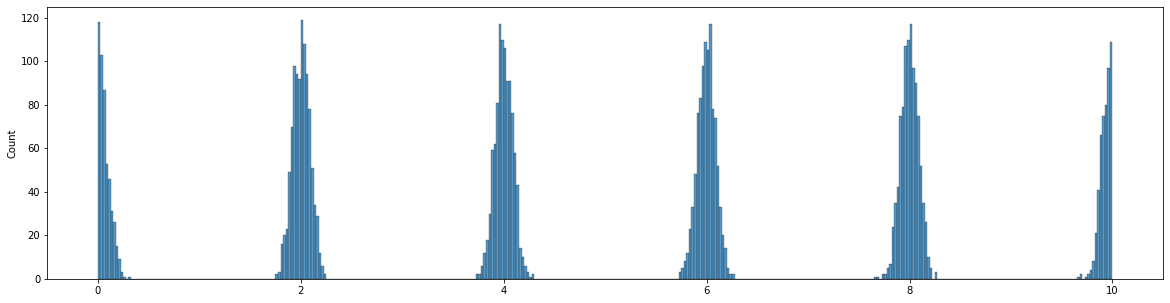

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

events=[]
for i in range(1000) :  #repeat to get enought samples to see the shape of the distribution
                                        #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds)
    events.extend(SI.noisySpacingTimeList(-1, .25, 10, rngseed=None))
print("number of events is {}".format(len(events)))
plt.figure(figsize=(20,5))
sns.histplot(events, bins=400)
plt.show()


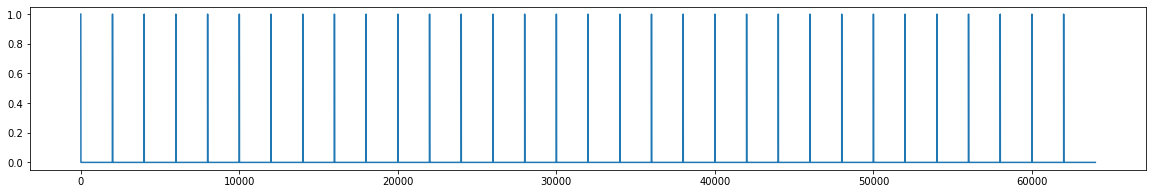

In [7]:
   #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds=p3)
elist = SI.noisySpacingTimeList(3, 0, 4, rngseed=9348754)
esig = SI.timeList2Sig(elist,16000,4)

plt.figure(figsize=(20,3))
plt.plot(esig)

#### Demo of synth interface for dataset generation
1) Reading parameters from config_file.json <br>
2) Enumerating parameter values. <br>
3) Generating datasets from enumerated parameters

In [8]:
if False :
    paramArr = []
    data = []

    config_file = './config_file.json'
    with open(config_file) as json_file:
        data = json.load(json_file)
        print("Reading parameters for generating ", data['soundname'], " texture.. ")
        for p in data['params']:
            print(p['pname'], ' Min: ', p['minval'], ' Max: ', p['maxval'])
            paramArr.append(p)

In [9]:
if False :
        # Config file Variables
    sr = data['samplerate']
    soundName = data["soundname"]
    outPath = data["outPath"]
    recordFormat = data["recordFormat"]
    paramRange = data["paramRange"]
    soundDuration = data["soundDuration"]
    numVariations = data["numVariations"]

In [10]:
if False :
    '''2 arrays for normalised and naturalised ranges'''
    userRange = []
    synthRange = []

    if paramRange == "Norm":
        for p in paramArr:
            userRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))    
        for p in paramArr:
            synthRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))
    else:
        for p in paramArr:
            userRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))    
        for p in paramArr:
            synthRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))

    userParam = list(itertools.product(*userRange))
    synthParam = list(itertools.product(*synthRange))
    userParam